# Data Transform

In this notebook, we will ask you a series of questions to evaluate your findings from your EDA. Based on your response & justification, we will ask you to also apply a subsequent data transformation. 

If you state that you will not apply any data transformations for this step, you must **justify** as to why your dataset/machine-learning does not require the mentioned data preprocessing step.

The bonus step is completely optional, but if you provide a sufficient feature engineering step in this project we will add `1000` points to your Kahoot leaderboard score.

You will write out this transformed dataframe as a `.csv` file to your `data/` folder.

**Note**: Again, note that this dataset is quite large. If you find that some data operations take too long to complete on your machine, simply use the `sample()` method to transform a subset of your data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


In [2]:
transactions = pd.read_csv("../data/bank_transactions.csv")

In [3]:
# Count of missing values per column
transactions.isnull().sum()


type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
non_predictive = ['nameOrig', 'nameDest']
target = 'isFraud'

In [5]:
# Drop non-predictive columns
transactions_cleaned = transactions.drop(columns=['nameOrig', 'nameDest'])

In [6]:
# Check final shape and column types
transactions_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   type            1000000 non-null  object 
 1   amount          1000000 non-null  float64
 2   oldbalanceOrg   1000000 non-null  float64
 3   newbalanceOrig  1000000 non-null  float64
 4   oldbalanceDest  1000000 non-null  float64
 5   newbalanceDest  1000000 non-null  float64
 6   isFraud         1000000 non-null  int64  
 7   isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 61.0+ MB


## Q1

Does your model contain any missing values or "non-predictive" columns? If so, which adjustments should you take to ensure that your model has good predictive capabilities? Apply your data transformations (if any) in the code-block below.

Answer here: Based on the data summary, there are no missing values in any of the columns. There are non-predictive columns present in the data set including 'type', which is currently an object type and must be encoded before being used in a machine learning model. The dataset also doesn't include any obvious ID or timestamp fields, which is good. 
The column 'isFlaggedFraud' should not be used as a feature for predicting 'isFraud' since it's a system-generated flag and would create label leakage. To transform the data set: Encode 'type' using one-hot encoding, drop 'isFlaggedFraud' to avoid data leakage and, ensure all features used in modeling are numeric.

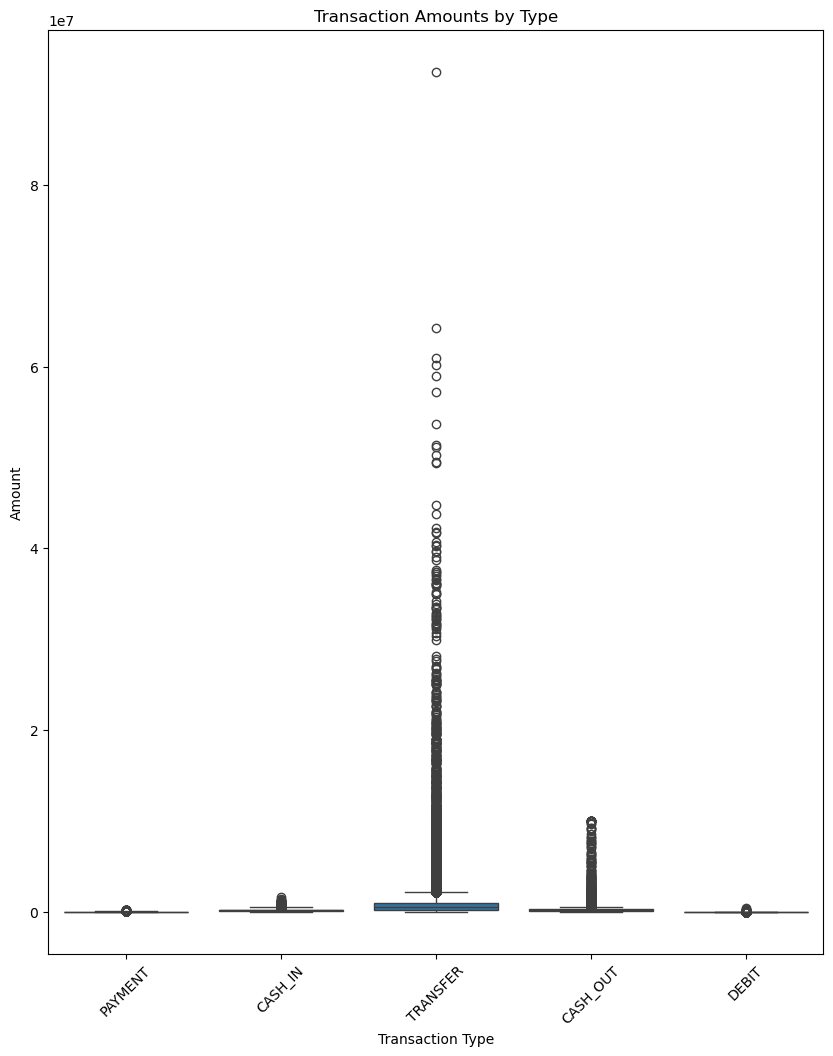

In [7]:
plt.figure(figsize=(10,12))
sns.boxplot(x='type', y='amount', data=transactions)
plt.title('Transaction Amounts by Type')
plt.ylabel('Amount')
plt.xlabel('Transaction Type')
plt.xticks(rotation=45)
plt.show()

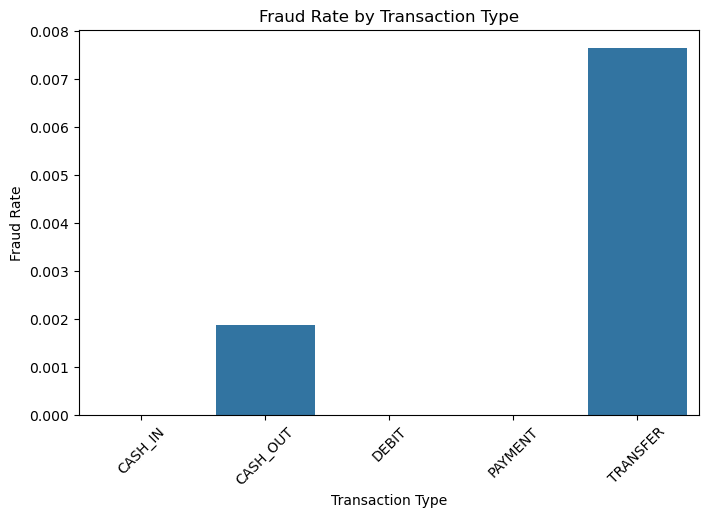

In [8]:
# Calculate fraud rate per type
fraud_by_type = transactions.groupby('type')['isFraud'].mean().reset_index()

# Bar plot of fraud rates
plt.figure(figsize=(8,5))
sns.barplot(x='type', y='isFraud', data=fraud_by_type)
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.xlabel('Transaction Type')
plt.xticks(rotation=45)
plt.show()

In [9]:
# One-hot encode the 'type' column
transactions_encoded = pd.get_dummies(transactions, columns=['type'], drop_first=True)


In [10]:
transactions_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   amount          1000000 non-null  float64
 1   nameOrig        1000000 non-null  object 
 2   oldbalanceOrg   1000000 non-null  float64
 3   newbalanceOrig  1000000 non-null  float64
 4   nameDest        1000000 non-null  object 
 5   oldbalanceDest  1000000 non-null  float64
 6   newbalanceDest  1000000 non-null  float64
 7   isFraud         1000000 non-null  int64  
 8   isFlaggedFraud  1000000 non-null  int64  
 9   type_CASH_OUT   1000000 non-null  bool   
 10  type_DEBIT      1000000 non-null  bool   
 11  type_PAYMENT    1000000 non-null  bool   
 12  type_TRANSFER   1000000 non-null  bool   
dtypes: bool(4), float64(5), int64(2), object(2)
memory usage: 72.5+ MB


## Q2

Do certain transaction types consistently differ in amount or fraud likelihood? If so, how might you transform the type column to make this pattern usable by a machine learning model? Apply your data transformations (if any) in the code-block below.

Answer here: Yes, transaction types differ significantly in both amount and fraud likelihood, and this pattern is visible in the visualizations presented. 
From the plot we can see that the TRANSFER transactions have the highest fraud rate, followed by CASH_OUT. While, CASH_IN, DEBIT, and PAYMENT transactions have almost little to no fraud. This indicates that transaction type is a very informative feature and can help the machine learning model differentiate between likely fraudulent and non-fraudulent transactions. To transform the type column and help the model assign risk levels to each transaction type independently, I chose to follow these steps:

One-hot encode it to let the model learn risk patterns associated with each type.

Drop one column (e.g., 'type_PAYMENT') to avoid interrelated predictors(if using linear models).

In [11]:
# Count of fraudulent vs. non-fraudulent transactions
transactions['isFraud'].value_counts()

isFraud
0    998703
1      1297
Name: count, dtype: int64

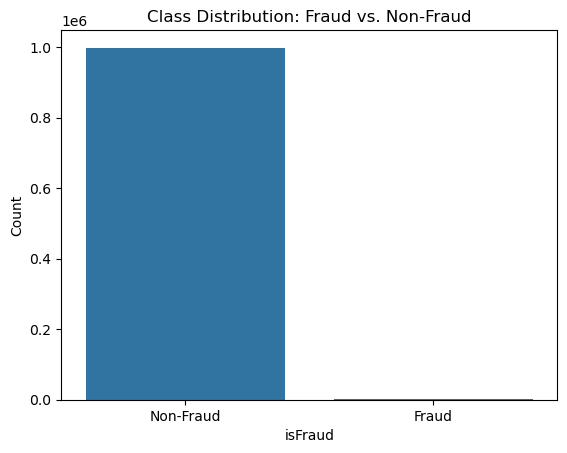

In [12]:
sns.countplot(x='isFraud', data=transactions)
plt.title('Class Distribution: Fraud vs. Non-Fraud')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

In [13]:
X = transactions_encoded.drop(columns=['isFraud', 'nameOrig', 'nameDest'], errors='ignore')
y = transactions_encoded['isFraud']

In [14]:
X.dtypes.value_counts()


float64    5
bool       4
int64      1
Name: count, dtype: int64

In [15]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [16]:
X = transactions_encoded.drop(columns=['isFraud', 'nameOrig', 'nameDest'], errors='ignore')
y = transactions_encoded['isFraud']

In [17]:
X.select_dtypes(include='object').nunique()

Series([], dtype: float64)

In [18]:
# START CLEAN: Make a fresh copy
df = transactions.copy()

# Drop target and any known non-predictive columns
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'], errors='ignore')
y = df['isFraud']

# If 'type' is not yet encoded, do it here
if 'type' in X.columns and X['type'].dtype == 'object':
    X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Confirm all features are now numeric
print("Still non-numeric columns:", X.select_dtypes(include='object').columns.tolist())


Still non-numeric columns: []


In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [20]:
print("Original class distribution:\n", y.value_counts())
print("Resampled shape:", X_resampled.shape)

# Check class balance
print("Resampled class distribution:\n", pd.Series(y_resampled).value_counts())

Original class distribution:
 isFraud
0    998703
1      1297
Name: count, dtype: int64
Resampled shape: (1997406, 10)
Resampled class distribution:
 isFraud
0    998703
1    998703
Name: count, dtype: int64


## Q3

After exploring your data, you may have noticed that fraudulent transactions are rare compared to non-fraudulent ones. What challenges might this pose when training a machine learning model? What strategies could you use to ensure your model learns meaningful patterns from the minority class? Apply your data transformations (if any) in the code-block below.

Answer here:
The dataset exhibits extreme class imbalance, with only 1,297 fraudulent transactions out of 1,000,000 — that’s less than 0.13%. This imbalance features several challenges including a bias toward majority class meaning that training the model on this data may teach it to always predict “non-fraud” and still achieve very high accuracy (e.g., 99.9%), while missing nearly all fraud cases. Secondly, poor recall for fraud, which means the model might fail to detect fraudulent transactions, therefore defeating the goal of fraud detection. Lastly, misleading metrics, which impact the accuracy. To address these challenges potential strategies include: helping the model learn meaningful patterns from the rare fraudulent cases, we can use resampling techniques, such as, oversampling the minority class (e.g., with SMOTE or simple replication), undersampling the majority class, a combination of both (e.g., SMOTEENN, SMOTETomek) or using class weights (especially for tree-based models or logistic regression).

## Bonus:

In [21]:
df = transactions.copy()

# Example: Binary feature for high amount (above 75th percentile)
df['high_amount'] = (df['amount'] > df['amount'].quantile(0.75)).astype(int)

# Example: Flag when balance goes to 0
df['zero_balance_after'] = (df['newbalanceOrig'] == 0).astype(int)

# Example: Fraud-prone transaction types
df['is_cash_or_transfer'] = df['type'].isin(['CASH_OUT', 'TRANSFER']).astype(int)

# Interaction feature: High amount + fraud-prone type
df['risky_combo'] = df['high_amount'] * df['is_cash_or_transfer']


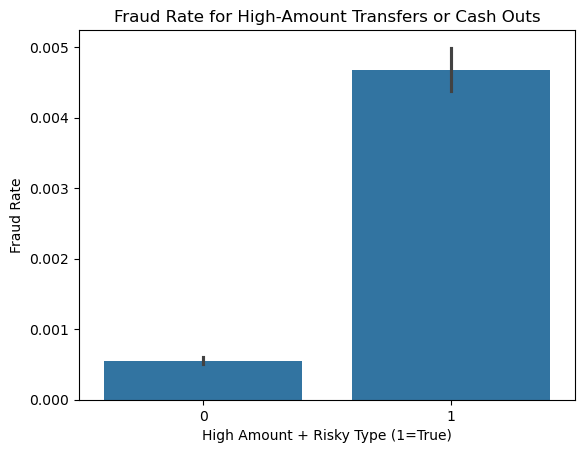

In [22]:
sns.barplot(x='risky_combo', y='isFraud', data=df)
plt.title('Fraud Rate for High-Amount Transfers or Cash Outs')
plt.xlabel('High Amount + Risky Type (1=True)')
plt.ylabel('Fraud Rate')
plt.show()


In [23]:
# write out newly transformed dataset to your folder
# Save to current working directory
df.to_csv('transformed_transactions.csv', index=False)

print("Transformed dataset saved as 'transformed_transactions.csv'")


Transformed dataset saved as 'transformed_transactions.csv'


## Bonus (optional)

Are there interaction effects between variables (e.g., fraud and high amount and transaction type) that aren't captured directly in the dataset? Would it be helpful to manually engineer any new features that reflect these interactions? Apply your data transformations (if any) in the code-block below.

Answer Here: Yes — there are interaction effects between variables that are not directly captured in the original dataset. This can be observed through the combination of the transaction type and amount (although individually they are informative). Through their combination high-value transactions that are also "risky types" (ex: TRANSFER or CASH_OUT), are more predictive of fraud. 